# Combing satelitte photos with historical weather data

Next step it combine different types of data to create another kind of model. The first model could asses the generel risk an area has of wildfire in next period of months. It could also be interesting to get an understanding weather an area is in risk of wildfire in the next month. Here the satellite photos are combined with historical weather data for the month before at the closest weather station.

In [1]:
# Packages:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import pandas as pd
import os


## Weather dataset

First the weather dataset should de downloaded and preprocces for modelling.

In [2]:
import math 
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/meriams/ABA-project-/main/weather2.csv', sep=';')
df = df.replace(',', '.', regex=True)

base_date = datetime(1899, 12, 30)  # Excel date 0 is 1900-01-01
excel_dates = df['Month/Year']
python_dates = pd.to_timedelta(excel_dates, unit='d') + base_date
df['Month/Year'] = python_dates.apply(lambda x: x.strftime('%B %Y'))
climateData = df
climateData

,Low,High,Rain,Month/Year,City,Lat,Long
0,41.4,50.2,7.58,January 2020,Portland,45.53,-122.69
1,36,51.9,1.55,February 2020,Portland,45.53,-122.69
2,38.2,54.6,2.43,March 2020,Portland,45.53,-122.69
3,44.1,64.9,0.79,April 2020,Portland,45.53,-122.69
4,51,69.7,22.1,May 2020,Portland,45.53,-122.69
...,...,...,...,...,...,...,...
463,41.6,95.4,0.06,August 2019,Princeton,42.82,-118.35
464,56.3,57.2,0.22,September 2019,Princeton,42.82,-118.35
465,45.4,69.1,0.13,October 2019,Princeton,42.82,-118.35
466,37.4,45.4,0.18,November 2019,Princeton,42.82,-118.35


## Creating dataset for the model

Next the satelitte photos for fire and no fire should be split into training, validation and test as the other models. Arrays for the weather data is also created in these steps.

### Fire

In [4]:
fire = pd.read_csv('https://raw.githubusercontent.com/meriams/ABA-project-/main/Oregon_data.csv')
fire.dropna(subset=['Long_DD'], inplace=True)
fire.dropna(subset=['Lat_DD'], inplace=True)

In [5]:
def closest_station(lat, long):
    distPortland = math.sqrt((45.53-lat)**2 + (-122.69-long)**2)
    distEugune = math.sqrt((44.08-lat)**2 + (-123.08-long)**2)
    distPrinceton = math.sqrt((42.82-lat)**2 + (-118.35-long)**2)
    
    if distPortland < distEugune and distPortland < distPrinceton:
        return 'Portland'
    elif distEugune < distPortland and distEugune < distPrinceton:
        return 'Eugune'
    else:
        return 'Princeton'

To distinguish the models and create value for the weather data, the same satelitte photo is added multiple times with different historical weather and whether there was a fire in the next months. This means that the same satelitte photo will have different labels so the model have to distinguish bewteen these based on the historical weather data.

In [7]:
folder_path_fire = "fire"

# Initialize lists to store the data
images_fire = []
labels_fire = []
weather_fire = []



# Loop through all the PNG files in the folder
for filename in os.listdir(folder_path_fire):
    if filename.endswith('.png'):
        spot = filename[:-4]
        try:
            img = f'{folder_path_fire}/{filename}'
            image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(image)

            date_string = fire.CreationDate[fire.FullFireNumber == spot].iloc[0]
            datetime_obj = datetime.strptime(date_string, '%m/%d/%Y %I:%M:%S %p')
            previous_month = datetime_obj - relativedelta(months=1)
            date = previous_month.strftime('%B %Y') # Getting the date from the month before fire
            lat = fire.Lat_DD[fire.FullFireNumber == spot].iloc[0]
            long = fire.Long_DD[fire.FullFireNumber == spot].iloc[0]
            station = closest_station(lat, long)

            weather_array = climateData.loc[(climateData['City'] == station) & (climateData['Month/Year'] == date), ['Low', 'High', 'Rain']]
            weather_array = weather_array.iloc[0]

            # Add the image array and its corresponding label (which is always 1) to the appropriate list

            images_fire.append(img_array)
            weather_fire.append(weather_array)
            labels_fire.append(1)
            
        except:
            pass
        
        for i in range(2,4):
            try:
                date_string = fire.CreationDate[fire.FullFireNumber == spot].iloc[0]
                datetime_obj = datetime.strptime(date_string, '%m/%d/%Y %I:%M:%S %p')
                previous_month = datetime_obj - relativedelta(months=i)
                date = previous_month.strftime('%B %Y') # Getting the date from the month before fire
                lat = fire.Lat_DD[fire.FullFireNumber == spot].iloc[0]
                long = fire.Long_DD[fire.FullFireNumber == spot].iloc[0]
                station = closest_station(lat, long)

                weather_array = climateData.loc[(climateData['City'] == station) & (climateData['Month/Year'] == date), ['Low', 'High', 'Rain']]
                weather_array = weather_array.iloc[0]

                # Add the image array and its corresponding label (which is always 1) to the appropriate list

                images_fire.append(img_array)
                weather_fire.append(weather_array)
                labels_fire.append(0)

            except:
                pass
            
train_len = int(len(images_fire)*0.6)
val_len = int(len(images_fire)*0.2+train_len)

# Convert the lists to numpy arrays
X_train_fire = np.array(images_fire[:train_len])
y_train_fire = np.array(labels_fire[:train_len])
X_val_fire = np.array(images_fire[train_len:val_len])
y_val_fire = np.array(labels_fire[train_len:val_len])
X_test_fire = np.array(images_fire[val_len:])
y_test_fire = np.array(labels_fire[val_len:])

X_weather_train_fire = np.array(weather_fire[:train_len]).astype(np.float32)
X_weather_val_fire = np.array(weather_fire[train_len:val_len]).astype(np.float32)
X_weather_test_fire = np.array(weather_fire[val_len:]).astype(np.float32)

### No fire

In [8]:
no_fire = pd.read_csv("https://raw.githubusercontent.com/meriams/ABA-project-/main/nofiredata.csv")
no_fire[['Lat', 'Long']] = no_fire['Coordinates'].str.split(',', expand=True)
no_fire

,Timestamp,Coordinates,ID Number,3months,Lat,Long
0,2021-10-19,"[43.270015266917845, -120.99866857931747]",764939464.0,2021-07-19,[43.270015266917845,-120.99866857931747]
1,2021-07-18,"[43.825736085970476, -119.6874162899144]",496131171.0,2021-04-18,[43.825736085970476,-119.6874162899144]
2,2017-11-23,"[42.08289588076026, -118.72530304625641]",981289671.0,2017-08-23,[42.08289588076026,-118.72530304625641]
3,2017-10-17,"[43.562008167727406, -120.7898484171608]",733336443.0,2017-07-17,[43.562008167727406,-120.7898484171608]
4,2021-10-10,"[42.54594266358967, -117.11395609618201]",627367907.0,2021-07-10,[42.54594266358967,-117.11395609618201]
...,...,...,...,...,...,...
16996,2021-07-11,"[44.40690426298669, -119.46586904573716]",109687911.0,2021-04-11,[44.40690426298669,-119.46586904573716]
16997,2020-11-25,"[45.40489909661745, -117.17554385743571]",436713213.0,2020-08-25,[45.40489909661745,-117.17554385743571]
16998,2018-10-01,"[42.76374037965357, -123.02278642727217]",812993126.0,2018-07-01,[42.76374037965357,-123.02278642727217]
16999,2019-11-16,"[42.64978782846754, -122.79984388563531]",687038889.0,2019-08-16,[42.64978782846754,-122.79984388563531]


In [9]:
folder_path_nofire = "no_fire"

# Initialize lists to store the data
# Initialize lists to store the data
images_nofire = []
labels_nofire = []
weather_nofire = []


# Loop through all the PNG files in the folder
for filename in os.listdir(folder_path_nofire):
    if filename.endswith('.png'):
        spot = float(filename[:-4])
        try:
            img = f'{folder_path_nofire}/{filename}'
            image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(image)
            date_string = no_fire.Timestamp[no_fire['ID Number'] == spot].iloc[0]
            datetime_obj = datetime.strptime(date_string, '%Y-%m-%d')
            previous_month = datetime_obj - relativedelta(months=1)
            date = previous_month.strftime('%B %Y') # Getting the date from the month before fire
            lat = no_fire.Lat[no_fire['ID Number'] == spot].iloc[0]
            lat = float(lat[1:])
            long = no_fire.Long[no_fire['ID Number'] == spot].iloc[0]
            long = float(long[:-1])
            station = closest_station(lat, long)

            weather_array = climateData.loc[(climateData['City'] == station) & (climateData['Month/Year'] == date), ['Low', 'High', 'Rain']]
            weather_array = weather_array.iloc[0]
            weather_array = [float(i) for i in weather_array]

            # Add the image array and its corresponding label (which is always 1) to the appropriate list
            images_nofire.append(img_array)
            weather_nofire.append(weather_array)
            labels_nofire.append(0)
        except:
            pass

train_len = int(len(images_nofire)*0.6)
val_len = int(len(images_nofire)*0.2+train_len)

# Convert the lists to numpy arrays
X_train_nofire = np.array(images_nofire[:train_len])
y_train_nofire = np.array(labels_nofire[:train_len])
X_val_nofire = np.array(images_nofire[train_len:val_len])
y_val_nofire = np.array(labels_nofire[train_len:val_len])
X_test_nofire = np.array(images_nofire[val_len:])
y_test_nofire = np.array(labels_nofire[val_len:])

X_weather_train_nofire = np.array(weather_nofire[:train_len]).astype(np.float32)
X_weather_val_nofire = np.array(weather_nofire[train_len:val_len]).astype(np.float32)
X_weather_test_nofire = np.array(weather_nofire[val_len:]).astype(np.float32)

The different arrays can afterwards be concated to a train, validation and test set for the satellite photos, weather data and the labels.

In [10]:
X_train = np.concatenate((X_train_fire, X_train_nofire))
Y_train = np.concatenate((X_weather_train_fire, X_weather_train_nofire))
z_train = np.concatenate((y_train_fire, y_train_nofire))

X_val = np.concatenate((X_val_fire, X_val_nofire))
Y_val = np.concatenate((X_weather_val_fire, X_weather_val_nofire))
z_val = np.concatenate((y_val_fire, y_val_nofire))

X_test = np.concatenate((X_test_fire, X_test_nofire))
Y_test = np.concatenate((X_weather_test_fire, X_weather_test_nofire))
z_test = np.concatenate((y_test_fire, y_test_nofire))

## Model building

Next the model can be build using the ResNew50 model on one side to analyze the satelitte photos as it had the best performance. A smaller RNN network is used to model the weather data before it is combined in one hidden layer and then predicting the risk

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense

# Load the ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Freeze ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Define the input tensor for the model
input_tensor1 = Input(shape=(224, 224, 3))

x = resnet_model(input_tensor1)
x = Flatten()(x)
x = Dense(130, activation='relu')(x)
x = keras.models.Model(inputs=input_tensor1, outputs=x)


input_tensor2 = Input(shape=(3))

y = Dense(22, activation='relu')(input_tensor2)
y = Dense(33, activation='relu')(y)
y = keras.models.Model(inputs=input_tensor2, outputs=y)

combined = tf.keras.layers.concatenate([x.output, y.output])

z = Dense(60, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = keras.models.Model(inputs=[x.input, y.input], outputs=z)

# Compile the combined model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1


In [12]:
combined_history  = model.fit([X_train, Y_train], z_train, batch_size=32, epochs=15, validation_data = ([X_val, Y_val], z_val))

Epoch 1/15


2023-04-25 01:01:39.407908: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


102/102 [==============================] - 61s 560ms/step - loss: 1.3798 - accuracy: 0.6312 - val_loss: 0.6135 - val_accuracy: 0.6854
Epoch 2/15
102/102 [==============================] - 59s 575ms/step - loss: 0.7390 - accuracy: 0.6824 - val_loss: 0.5303 - val_accuracy: 0.7553
Epoch 3/15
102/102 [==============================] - 57s 560ms/step - loss: 0.6040 - accuracy: 0.7265 - val_loss: 0.5267 - val_accuracy: 0.7571
Epoch 4/15
102/102 [==============================] - 57s 557ms/step - loss: 0.5930 - accuracy: 0.7075 - val_loss: 0.5267 - val_accuracy: 0.7617
Epoch 5/15
102/102 [==============================] - 58s 565ms/step - loss: 0.5747 - accuracy: 0.7229 - val_loss: 0.5361 - val_accuracy: 0.7580
Epoch 6/15
102/102 [==============================] - 64s 628ms/step - loss: 0.5561 - accuracy: 0.7244 - val_loss: 0.5324 - val_accuracy: 0.7553
Epoch 7/15
102/102 [==============================] - 58s 573ms/step - loss: 0.5658 - accuracy: 0.7272 - val_loss: 0.5627 - val_accuracy: 0.7

In [13]:
loss, accuracy = model.evaluate([X_test, Y_test], z_test)
print('Test accuracy:', accuracy)

35/35 [==============================] - 15s 413ms/step - loss: 0.5146 - accuracy: 0.7541
Test accuracy: 0.7541284561157227


35/35 [==============================] - 15s 407ms/step


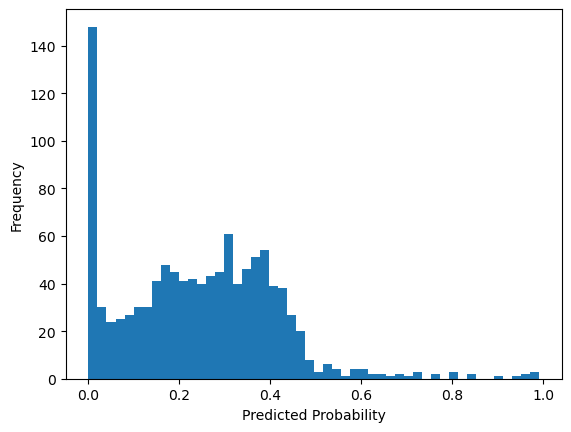

In [14]:
z_pred = model.predict([X_test, Y_test])
plt.hist(z_pred, bins=50)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Partial conclussion

The model is skewed towards 0 beacause of the added data, but this new model also has some difference in how it predict. The predictions is lower in value, which was the expected as there is more uncertainty in the risk for the next month than there is for half a year. The models is therefore also expected to have a lower accuracy.

The models shows a fairly well accuracy and has value in that it's very useful in being able to identify what areas  has a close to 0% chance of wildfire, while a lot areas can be predicted to 30-40% and some areas at even higher risk for the next month. The prediction method is therefore another effective tool and can help agencies help to allocate resources in the short term.